In [1]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.linear_model as skl_lm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score
from sklearn import preprocessing
from sklearn import neighbors

import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib notebook
plt.style.use('seaborn-white')

In [2]:
np.random.seed(42)

def f(x1, x2):
    return 10 + x1 + 2*x2

n = 100
X = pd.DataFrame(np.c_[
    np.random.normal(loc=2, size=n), 
    np.random.normal(loc=3, scale=2, size=n)
], columns=["x1", "x2"])

y = f(X["x1"], X["x2"]) + np.random.normal(size=n)

<IPython.core.display.Javascript object>


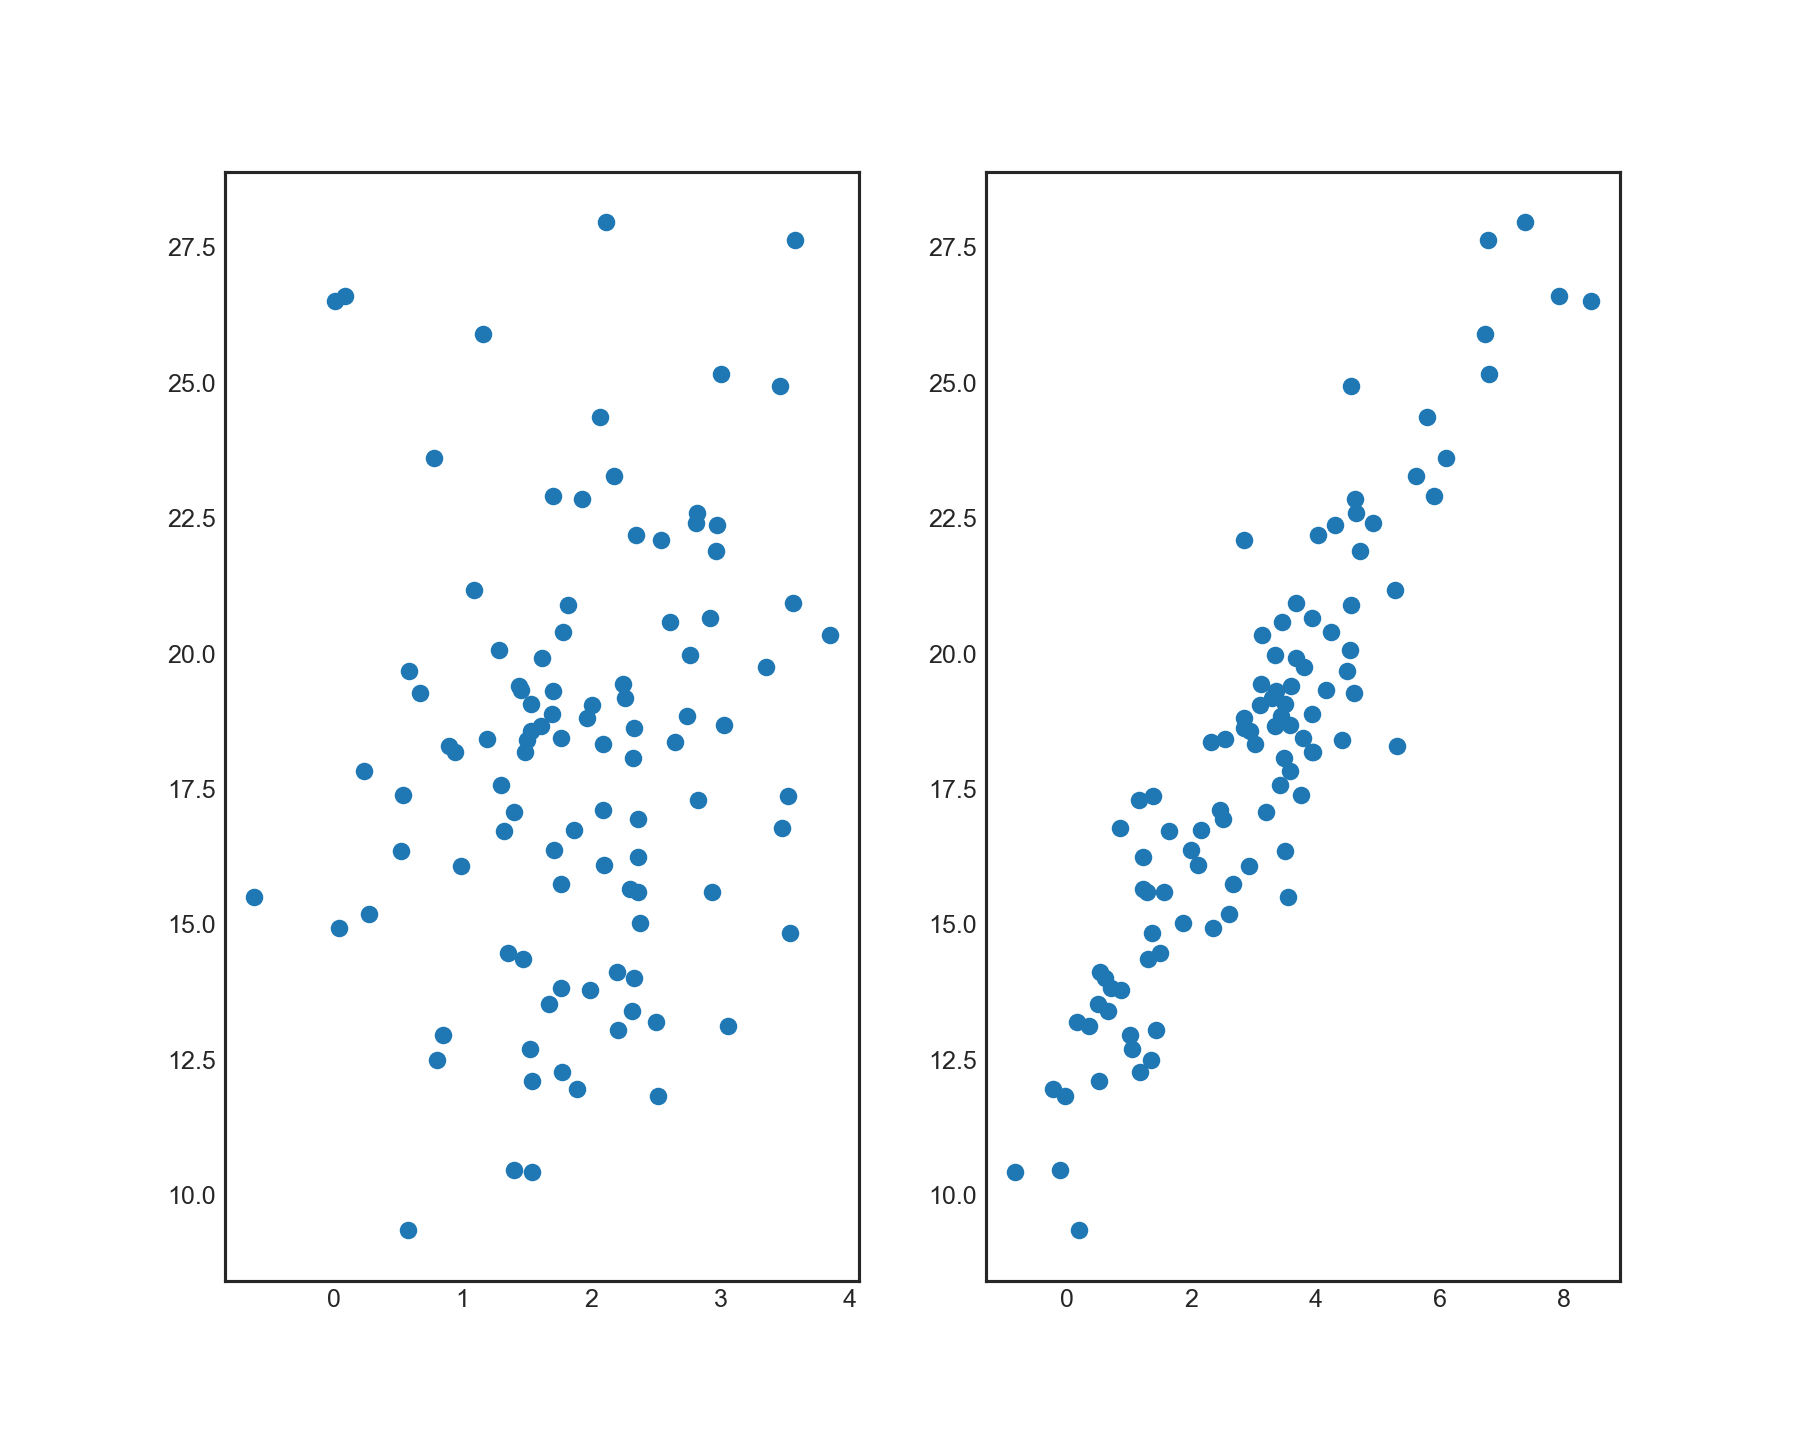

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
ax1.scatter(X["x1"], y)
ax2.scatter(X["x2"], y)

<IPython.core.display.Javascript object>


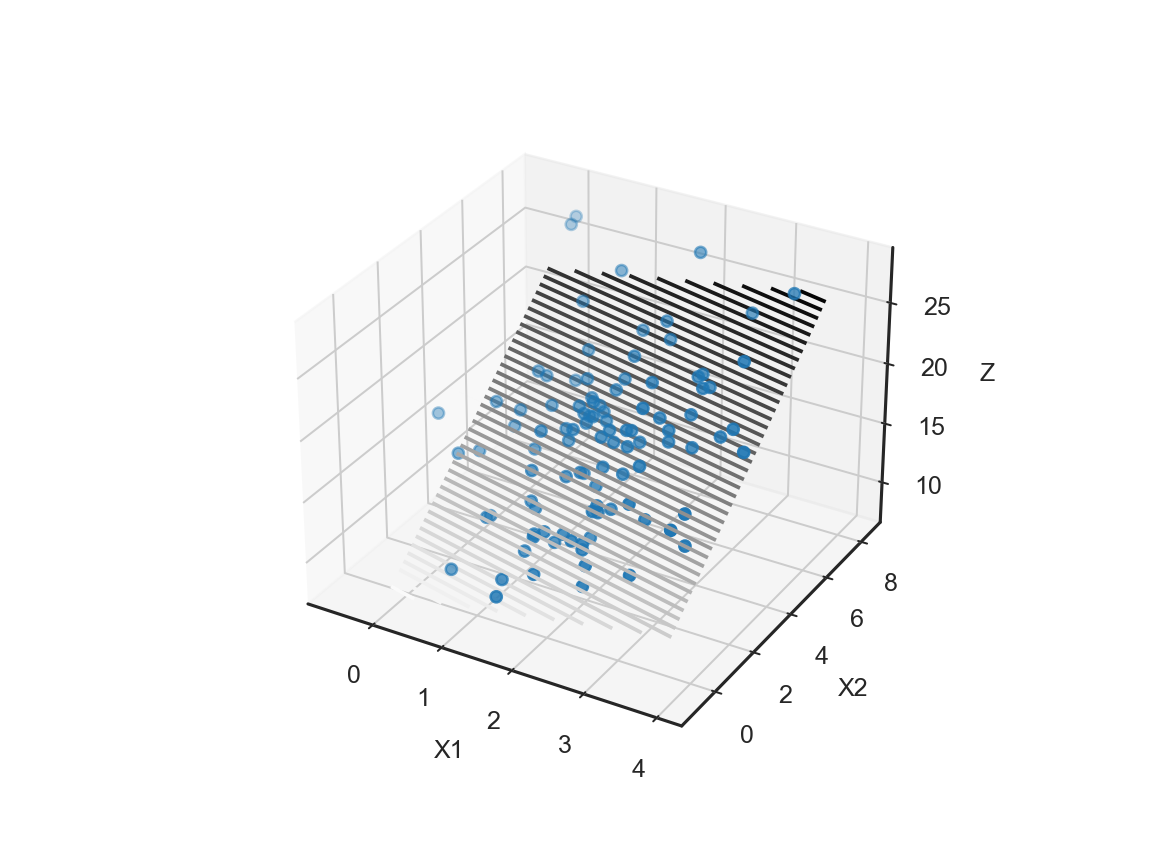

Text(0.5, 0, 'Z')

In [4]:
fig = plt.figure()
ax = plt.axes(projection='3d')

ix = np.linspace(0, 4, 30)
iy = np.linspace(-1, 7, 30)

Xg, Yg = np.meshgrid(ix, iy)
Z = f(Xg, Yg)

ax.contour3D(Xg, Yg, Z, 50, cmap='binary')
ax.scatter3D(X.iloc[:, 0], X.iloc[:, 1], y)

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Z')


In [5]:
import faraway.utils 
from statsmodels.tools import add_constant

b1_hat = np.random.normal()

lmod1 = sm.OLS(y - b1_hat * X["x1"], add_constant(X["x2"])).fit()
lmod1.sumary()

       coefs stderr tvalues pvalues
const 13.958  0.405   34.43  0.0000
x2     1.860  0.113   16.47  0.0000

n=100 p=2 Residual SD=2.144 R-squared=0.73


In [6]:
b0_hat = lmod1.params["const"]
b2_hat = lmod1.params["x2"]

lmod2 = sm.OLS(y - b2_hat * X["x2"], add_constant(X["x1"])).fit()
lmod2.sumary()

       coefs stderr tvalues pvalues
const 10.134  0.256   39.66  0.0000
x1     1.188  0.122    9.76  0.0000

n=100 p=2 Residual SD=1.099 R-squared=0.49


In [7]:
b1_hat = np.random.normal()

b2s = []
b1s = [b1_hat]
b0s = []
print("Init b1: ", b1_hat)

for i in range(100):
    lmod1 = sm.OLS(y - b1_hat * X["x1"], add_constant(X["x2"])).fit()
    b2_hat = lmod1.params["x2"]
    b2s.append(b2_hat)
    
    lmod2 = sm.OLS(y - b2_hat * X["x2"], add_constant(X["x1"])).fit()
    b1_hat = lmod2.params["x1"]
    b1s.append(b1_hat)
    b0s.append(lmod2.params["const"])
    
    if i % 5 == 0:
        print("Iteration ", i, ": b2_hat->", b2_hat, "b1_hat->", b1_hat, "const->", lmod2.params["const"])

Init b1:  -0.5601810401969696
Iteration  0 : b2_hat-> 1.8778314107404592 b1_hat-> 1.1928450502428405 const-> 10.07118804712561
Iteration  5 : b2_hat-> 1.9938616113982914 b1_hat-> 1.2260893643467738 const-> 9.654885111765104
Iteration  10 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteration  15 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteration  20 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteration  25 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteration  30 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteration  35 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteration  40 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteration  45 : b2_hat-> 1.993861611657365 b1_hat-> 1.226089364421002 const-> 9.654885110835579
Iteratio

<IPython.core.display.Javascript object>


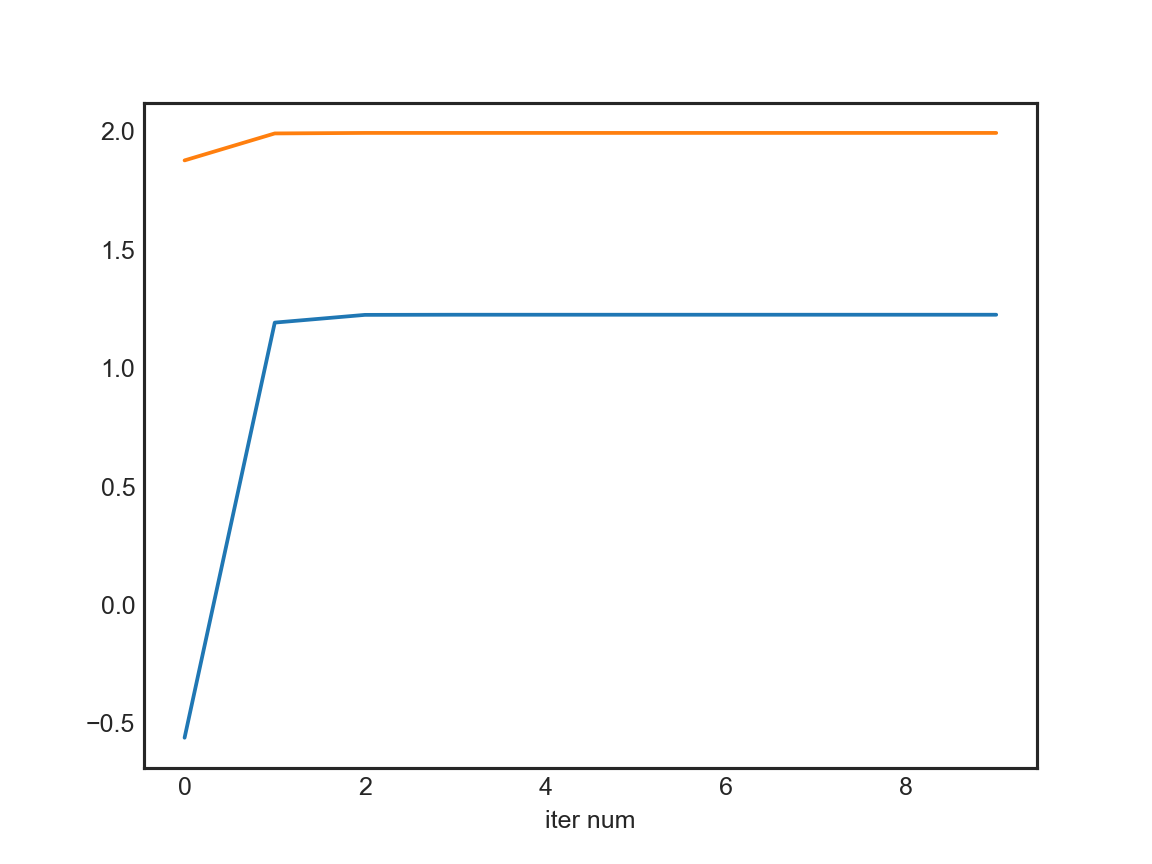

Text(0.5, 0, 'iter num')

In [8]:
f, ax = plt.subplots()
# ax.plot(np.arange(20), b0s[:20], label="b0")
ax.plot(np.arange(10), b1s[:10], label="b1")
ax.plot(np.arange(10), b2s[:10], label="b2")
ax.set_xlabel("iter num")

It has converged in 10 iterations

In [9]:
lmod_full = sm.OLS(y, add_constant(X)).fit()
lmod_full.sumary()

      coefs stderr tvalues pvalues
const 9.655  0.323   29.86  0.0000
x1    1.226  0.120   10.21  0.0000
x2    1.994  0.057   34.86  0.0000

n=100 p=3 Residual SD=1.075 R-squared=0.93


As expected, the results from two approaches are the same

## Increasing `p`

In [19]:
p = 100
n = 1000

intercept = 10
betas = np.random.laplace(scale=5, size=p)
# betas = np.random.gamma(0.1, scale=50, size=p)
def f(X):
    return X @ betas + intercept

X = pd.DataFrame(
    np.array(
        [np.random.normal(
            loc=np.random.uniform(1, 50), 
            scale=np.random.uniform(1, 10),
            size=n
        )
        for i in range(p)]
    ).T, 
    columns=["x" + str(i) for i in range(1, p+1)]
)

y = f(X) + np.random.normal(
    # little bit of heterogeneity
    # in error
    scale=np.random.exponential(5, size=n), 
#     scale=np.random.uniform(0, 5, size=n), 
)

<IPython.core.display.Javascript object>


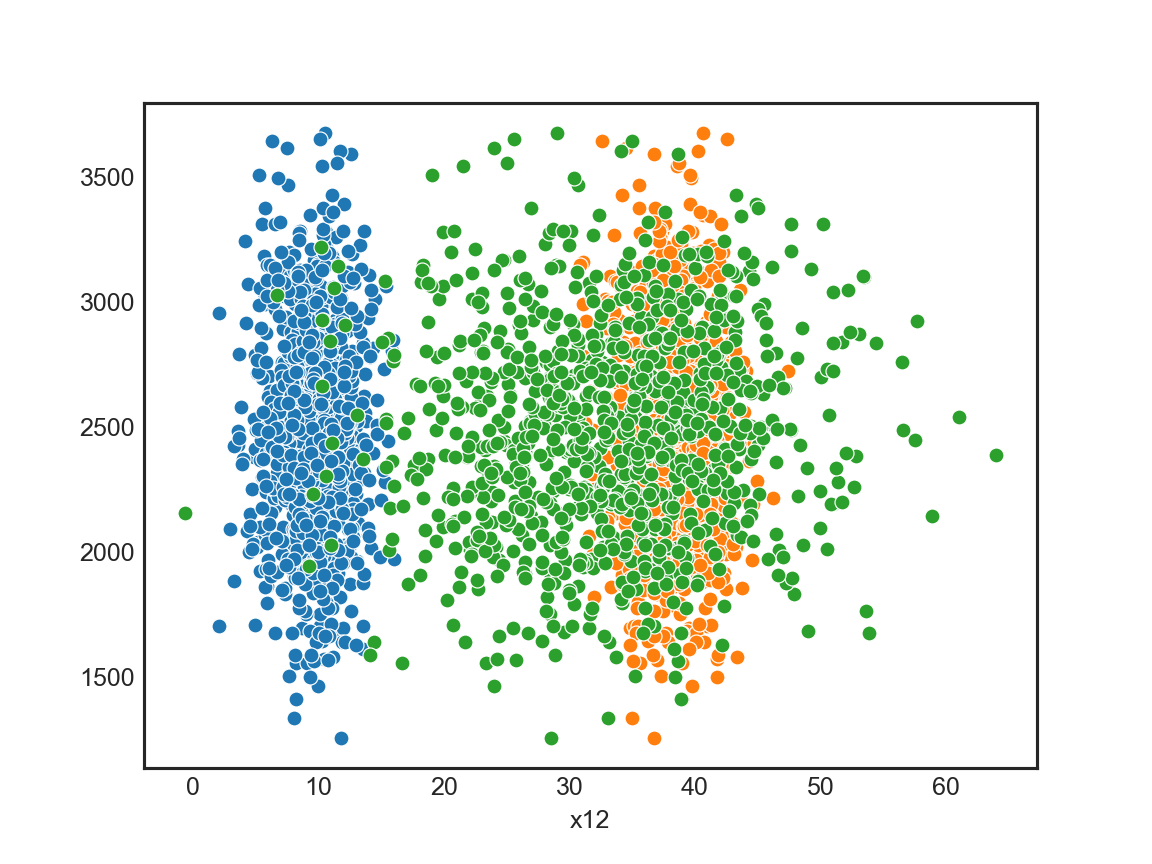

<AxesSubplot:xlabel='x12'>

In [20]:
fig, ax = plt.subplots()
sns.scatterplot(x="x12", y=y, data=X, ax=ax)
sns.scatterplot(x="x35", y=y, data=X, ax=ax)
sns.scatterplot(x="x3", y=y, data=X, ax=ax)

In [21]:
pd.concat([y, X], axis=1).corr()[0].sort_values()

x89   -0.247074
x80   -0.244579
x60   -0.243968
x21   -0.218314
x62   -0.215219
         ...   
x11    0.210188
x73    0.240507
x82    0.287635
x71    0.304698
0      1.000000
Name: 0, Length: 101, dtype: float64

In [29]:
lmod_full = sm.OLS(y, add_constant(X)).fit()
# lmod_full.sumary()
np.abs(lmod_full.params[1:] - betas).sum()

3.8461306386198024

In [40]:
a = pd.Series({1: "a", 2: "b", 3:"c"})
a.drop([1, 2])

3    c
dtype: object

In [72]:
iter_n = 100
betas_list = pd.DataFrame(
    {"x" + str(i): np.zeros(iter_n) for i in range(p+1)}
)

for i in range(1, iter_n):
    previous_betas = betas_list.iloc[i-1]
    current_betas = betas_list.iloc[i]
    for j in range(1, p+1):
        X_not_j = X.drop(columns="x" + str(j))
        lmod_j = sm.OLS(
            y - X_not_j @ previous_betas.drop(["x0", "x" + str(j)]), 
            add_constant(X["x" + str(j)])
        ).fit()
        current_betas["x" + str(j)] = lmod_j.params["x" + str(j)]
        current_betas["x0"] = lmod_j.params["const"]

In [73]:
final_betas = betas_list.iloc[-1]
np.abs(final_betas[1:] - lmod_full.params[1:]).sum()

2.112893193739751e-12

In [75]:
final_betas[0], lmod_full.params["const"]

(12.92051761171995, 12.920517611730247)

The same

To get a sense of convergence speed:

<IPython.core.display.Javascript object>


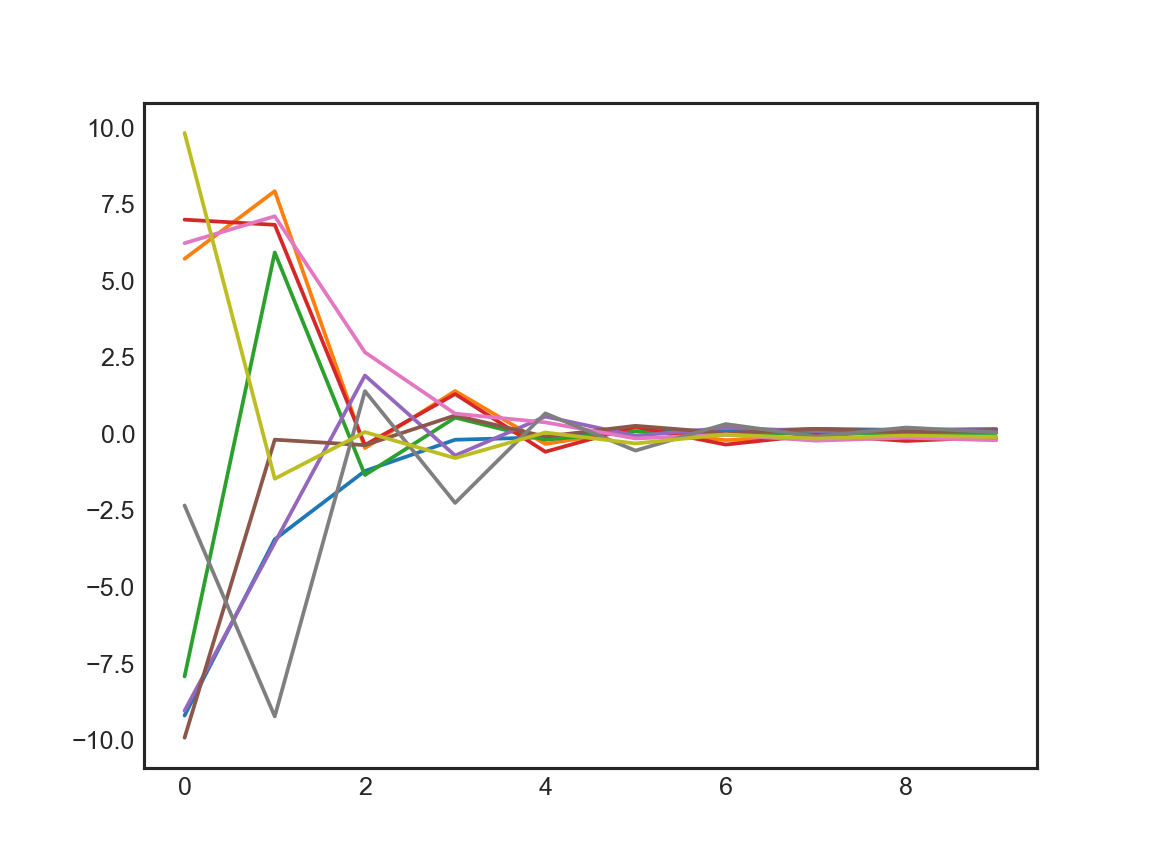

In [95]:
from sklearn.preprocessing import scale
betas_list_norm = pd.DataFrame(scale(betas_list), columns=betas_list.columns)

fig, ax = plt.subplots()

for i in range(1, 10):
    ax.plot(np.arange(10), betas_list_norm.loc[:9, "x"+str(i)])